In [1]:
from brian2 import *
from brian2tools import *
%matplotlib inline
np.set_printoptions() 
#np.set_printoptions(threshold=12)


In [2]:
def fancy_print_vector(v):
    if v.shape[1] > 24:
        # Fancy formating for slots_per_vector that are longer than 24 bits_per_slot 
        # shows start and end of slot values.
        for kk in range(v.shape[0]):
            print(f"slot[{kk:2d}]:"
                  f"{((v[kk]).astype(int))[:12]} ... {((v[kk]).astype(int))[-12:]}, "
                  f"Argmax bit pos=[{np.argmax(v[kk])}]")
    else:
        for kk in range(v.shape[0]):
            print(f"slot[{kk:2d}]:"
                  f"{((v[kk]).astype(int))}, "
                  f"Argmax bit pos=[{np.argmax(v[kk])}]")

This code uses the Brian2 neuromorphic simulator code to implement
 a version of role/filler binding and unbinding based on the 
paper :High-Dimensional Computing with Sparse Vectors" by Laiho et al 2016. 
The vector representation is a block structure comprising slots_per_vector 
where the number of slots_per_vector is the vector dimension. In each slot there are a
number of possible bit positions with one bit set per slot. 
In this implementation we implement the role/filler binding and unbinding 
operations in Brian2 by representing each slot as a neuron and the time delay
 of the neuron's spike as the bit position.  

To ensure that the Brian2 network is performing correctly the first section of the code 
computes the expected sparse bound vector.  
The neuromorphic equivalent is implemented as two Brian2 networks.  The first network (net1) implements
the role/filler binding and the second netwok (net2) implements the role/filler unbinding and the clean-up memory
operation which compares the unbound vector with all the memory vectors to find the best match.
The sparse bound vector resulting from net1 is passed to net2 to initiate the unbinding.

## Init base vars

In [3]:
# Init base vars
show_bound_vecs_slot_detail = False

slots_per_vector = 100 # This is the number of neurons used to represent a vector
bits_per_slot = 100 # This is the number of bit positions
mem_size = 500 # The number of vectors against which the resulting unbound vector is compared
Num_bound = 5 # The number of vectors that are to be bound
input_delay = bits_per_slot # Time delay between adding cyclically shifted vectors to construct the bound vector is set to 'bits_per_slot' milliseconds.

#NB all timings use milliseconds and we can use a random seed if required.
np.random.seed(54321)

target_neuron = 1
y_low=target_neuron-1 # This is used to select the lowest index of the range of neurons that are to be displayed
y_high=target_neuron+1 # This is used to select the highest index of the range of neurons that are to be displayed

delta = (2*Num_bound) * bits_per_slot #This determins the time period over which the Brian2 simulation is to be run.



## Create a set of sparse VSA vectors
Generate a random matrix (P_matrix) which represents all of the sparse vectors that are to be used.
This matrix has columns equal to the number of slots_per_vector in each vector with the number of rows equal to the memory size (mem_size)


In [4]:
P_matrix = np.random.randint(0, bits_per_slot, size=(mem_size,slots_per_vector))
Role_matrix = P_matrix[::2]
Val_matrix = P_matrix[1::2]

## Demonstration of modulo addition binding

In [5]:
test_target_neuron = target_neuron  # Change this to try different columns e.g. 0, 1, 2....
print(f"Showing modulo {bits_per_slot} addition role+filler bind/unbind for target column {test_target_neuron}\n") 
for n in range(0,2*Num_bound,2):
    bind_val = (P_matrix[n][test_target_neuron]+P_matrix[n+1][test_target_neuron])%bits_per_slot
    print(f"\t{P_matrix[n][test_target_neuron]:2d}+{P_matrix[n+1][test_target_neuron]:2d}="
          f"{P_matrix[n][test_target_neuron]+P_matrix[n+1][test_target_neuron]:2d} %"
          f" {bits_per_slot} = {bind_val:2d} Bind")    

    unbind_val = (bind_val-P_matrix[n+1][test_target_neuron]) % bits_per_slot 
    print(f"\t{bind_val:2d}-{P_matrix[n+1][test_target_neuron]:2d}="
      f"{bind_val-P_matrix[n+1][test_target_neuron]:2d} %"
      f" {bits_per_slot} = {unbind_val:2d} Unbind\n")    


Showing modulo 100 addition role+filler bind/unbind for target column 1

	10+51=61 % 100 = 61 Bind
	61-51=10 % 100 = 10 Unbind

	 0+69=69 % 100 = 69 Bind
	69-69= 0 % 100 =  0 Unbind

	22+77=99 % 100 = 99 Bind
	99-77=22 % 100 = 22 Unbind

	30+31=61 % 100 = 61 Bind
	61-31=30 % 100 = 30 Unbind

	27+63=90 % 100 = 90 Bind
	90-63=27 % 100 = 27 Unbind



# Empirical calc 
This section of the code computes the theoretical values for the sparse vector (which can then be compared with
the output of the net1 neuromorphic circuit. It then computes the expected number of bits_per_slot that will align in the clean-up memory operation (which can then be compared with the net2 neuromorphic circuit output).


## Create sparse representation of the bound vector

In [6]:
# print the cyclically shifted version of the vectors that are to be bound
np.set_printoptions(threshold=24)
np.set_printoptions(edgeitems=11)

for n in range(0, Num_bound):
    print(np.roll(P_matrix[n], n))

np.set_printoptions()

# Init sparse bound vector (s_bound) with zeros
s_bound = np.zeros((slots_per_vector, bits_per_slot))  # Create a slotted vector with

#Create sparse representation of the bound vector
#We take pairs of vector and bind them together and in each slot
# we cyclically shift the bit position of the filler vector by the 
# bit position of the role vector then we add them together to get the vector s_bound


# Do the binding
for n in range(0, Num_bound):
    for s in range(0, slots_per_vector):  # For each slot
        role_pos = Role_matrix[n][s]   # Position of the set bit in this role vector for this slot
        filler_pos = Val_matrix[n][s]  # Position of the set bit in this value vector for this slot
        b = (filler_pos+role_pos) % bits_per_slot  # Get new 'phase' (bit position) to set in the bound vector's slot
        s_bound[s][b] += 1


[81 10 26 96 22 78 18 72 71 10 98 ... 18 37 76 16 21  9 18  4 25 46 28]
[81 64 51 34 27 17 11 94 75 98 76 ...  4 63 38 90 33 86 44 21 38 99 97]
[34 63 41  0 34 93 97 95 30 30 90 ... 19 84  6 82 93  9 98 25 93 19 75]
[56 95  6 33 69 31 82 11 27 56 42 ... 61 80 26 72 98 22 91 51 33 85 99]
[74 60 76 13 55 22 87 59 65 89  8 ... 80 18 27 77 22 54 75 63 71 35 76]


In [7]:
if show_bound_vecs_slot_detail:
    np.set_printoptions(formatter={'int':lambda x: f"{x:2d}"})
    print()
    fancy_print_vector(s_bound)

    np.set_printoptions()

## Make s_bound sparse using the argmax function which finds the bit position with the highest random value.

In [8]:
# Make s_bound sparse using the argmax function which finds the bit position with the highest random value.
np.set_printoptions(threshold=24)
np.set_printoptions(edgeitems=11)
print("\nResultant Sparse vector, value indicates 'SET' bit position in each slot. "
      "\n(Note, a value of '0' means bit zero is set).\n")

sparse_bound = np.array([np.argmax(s_bound[s]) for s in range(0,slots_per_vector)])
print(sparse_bound)
print()
np.set_printoptions()


Resultant Sparse vector, value indicates 'SET' bit position in each slot. 
(Note, a value of '0' means bit zero is set).

[81 61 19 21 68  3 12  9  8 62 17 ...  6 15 15 64  1 53  1  1 24 16  9]



# Perform the unbinding

Unbind the vector sparse_bound vector and compare with each of the vectors in the P_matrix couting the
number of slots_per_vector that have matching bit positions. This gives the number of spikes that should line up 
in the clean up memory operation.

In [9]:
np.set_printoptions(threshold=24)
np.set_printoptions(edgeitems=11)

hd_threshold = 0.1
results_set = []
results = None
miss_matches = []
min_match = slots_per_vector
for nn in range(0, len(Role_matrix)):
    # for pvec in P_matrix:
    pvec = Role_matrix[nn]
    results = []
    for test_vec in Val_matrix:
        unbound_vals = np.array([(sparse_bound[ss] - pvec[ss]) % bits_per_slot for ss in range(0, slots_per_vector)])
        match = np.count_nonzero(unbound_vals == test_vec)
        results.append(match)

    win_indx = np.argmax(results)
    max_count = np.max(results)
    hd = max(results) / slots_per_vector
    # print(nn, end=' ')
    if hd > hd_threshold:
        print(f"Role_vec_idx[{nn:02d}], Val_match_idx[{win_indx:02d}]:\t{np.array(results)}")
        if max_count <= min_match:
            min_match = max_count
    else:
        # store the a failed match
        miss_matches.append((nn, win_indx, np.array(results)))
    
    results_set.append(results)
np.set_printoptions()

Role_vec_idx[00], Val_match_idx[00]:	[20  0  1  3  3  1  0  2  1  2  1 ...  0  2  2  0  1  0  1  0  4  0  1]
Role_vec_idx[01], Val_match_idx[01]:	[ 1 29  3  1  1  2  0  1  1  0  1 ...  0  0  1  2  1  0  0  1  2  1  1]
Role_vec_idx[02], Val_match_idx[02]:	[ 0  0 22  1  0  0  2  0  2  1  1 ...  0  0  2  0  0  0  1  2  1  2  1]
Role_vec_idx[03], Val_match_idx[03]:	[ 1  0  2 19  0  0  1  1  0  2  0 ...  0  0  1  0  1  0  1  0  1  1  3]
Role_vec_idx[04], Val_match_idx[04]:	[ 0  1  0  0 18  1  0  3  2  2  2 ...  0  3  1  1  1  1  0  3  1  1  2]


In [10]:
print("\nShowing failed matches:\n")
for fm in miss_matches:
    print(f"Role_vec_idx[{fm[0]:02d}], Val_match_idx[{fm[1]:02d}]:\t{fm[2]}")


Showing failed matches:

Role_vec_idx[05], Val_match_idx[94]:	[3 2 1 0 1 0 0 0 2 2 0 ... 0 2 0 1 0 0 1 3 1 1 1]
Role_vec_idx[06], Val_match_idx[116]:	[0 0 0 2 0 1 1 0 1 0 0 ... 1 1 1 0 1 2 1 0 0 2 2]
Role_vec_idx[07], Val_match_idx[27]:	[0 1 0 1 1 1 3 1 1 2 2 ... 0 0 2 0 1 2 0 3 0 1 3]
Role_vec_idx[08], Val_match_idx[44]:	[2 0 1 0 0 0 0 1 0 0 2 ... 2 2 1 1 0 0 3 2 2 0 1]
Role_vec_idx[09], Val_match_idx[159]:	[1 2 0 1 0 0 1 1 2 0 1 ... 1 2 0 2 0 0 0 1 0 1 1]
Role_vec_idx[10], Val_match_idx[49]:	[0 2 2 0 3 3 1 1 2 1 0 ... 0 1 2 3 2 0 0 2 0 3 0]
Role_vec_idx[11], Val_match_idx[15]:	[0 2 2 0 2 1 1 0 2 1 0 ... 2 0 1 0 2 1 2 0 1 0 3]
Role_vec_idx[12], Val_match_idx[42]:	[2 2 1 0 0 1 3 1 0 0 1 ... 2 2 1 0 1 1 0 3 0 2 1]
Role_vec_idx[13], Val_match_idx[23]:	[0 1 0 1 3 0 0 0 1 1 1 ... 0 0 0 3 0 0 0 1 1 0 0]
Role_vec_idx[14], Val_match_idx[174]:	[2 0 0 1 1 0 3 3 1 0 1 ... 1 0 0 1 0 1 2 0 0 0 0]
Role_vec_idx[15], Val_match_idx[40]:	[2 2 0 0 1 0 1 2 1 0 2 ... 0 3 2 1 2 1 1 0 2 3 0]
Role_vec_idx[1

# Binding: Brian 2 Code - SIMPLIFIED CIRCUIT ==================

![title](img/Fig10.png)

Generate the time delay data_matrix from the so that the input vector time delay in each slot plus the delay matrix line up at the number of bits_per_slot per slot (e.g. a time delay in slot 0 of the input vector of say 10 will have a corresponding delay of 90 in the corresponding data_matrix so that if this vector is received then the match condition is an input potential to the neuron at 100)


---------------------------------------------------------------------------------------------------------------

This section of the code implements the role/filler binding in the Brian2 network (net1)

In [11]:
net1=Network()

#We first create an array of time delays which will be used to select the first Num_bound vectors from 
# the P_matrix with a time delay (input_delay) between each vector.


#Calculate the array for the input spike generator
array1 = np.ones(mem_size) * slots_per_vector * bits_per_slot

# The input spike generator creates pairs of spkies corresponding to contiguous pairs of vectors from the memory that are
# going to be bound together (i.e., vector_0 & vector_1 then vector_2 and Vector_3 etc.)

for b in range(0,2*Num_bound,2):
    array1[b] = (b)*input_delay
    array1[b+1] = (b)*input_delay

# Create the corresponding spike generator group.
P = SpikeGeneratorGroup(mem_size,np.arange(mem_size), (array1)*ms)

net1.add(P)

#We now define the set of equation and reset definitions that will be used to generate the neuron action
#potentials and spike reset operations.  Note that we make use of the Brian2 refractory operation.

equ1 ='''
dv/dt = (I)/tau : 1 
I : 1
tau : second
'''

equ2 = '''
dv/dt = -v/tau : 1 (unless refractory)
tau : second
ts : second
'''
reset1 = '''
I=0.0
v=0.0
'''

reset2 = '''
ts=t
v=0.0
'''


# The G1 neurons perform the addition operation in the two selected vectors. Equ1 is a linearly increasing function 
# with a time constant of 2*bits_per_slot*ms (I=1.0).  The G1 neuron group is stimulated from the P spike generator group with
# spikes that simultaneously select a role and filler vector using the time delay on the G1 dendrites obtained from the P_matrix (S0.delay)
# On receiving the first spike from either role or filler vector the value of I
# is changed to 0.0 which holds the neuron potential constant until the second spike is received when I = -1.0 and the neuron
#  potential decays until the threshold value v<0.0 when it fires to give the required modulus addition. The value of I is 
# reset to 1.0 using the spike from the P spikemonitorgroup (S1) and the next two vectors are added.

G1 = NeuronGroup(slots_per_vector, equ1,
                 threshold='v < 0.0 or v>=1.0', reset=reset1, method='euler')

G1.v =0.0
G1.I = 1.0
G1.tau = 2 * bits_per_slot * ms

net1.add(G1)


S0 = Synapses(P, G1, 'w : 1',on_pre= 'I = (I-1)')

range_array1 = range(0, slots_per_vector)
for n in range(0,mem_size):
    S0.connect(i=n,j=range_array1)     
S0.delay = np.reshape(P_matrix, mem_size * slots_per_vector) * ms

net1.add(S0)


SP1 = Synapses(P, G1, 'w : 1',on_pre= 'I=1.0')

for n in range(0,mem_size):
    SP1.connect(i=n,j=range_array1)    

net1.add(SP1)

#The G2 neurons select the earliest spike across all of the Num_bound cycles by remembering the time of the previous spike 
#such that if there is no earlier spike from the G1 neurons this spike is regenerated.  The refractory property of the 
#neuron is used to supress any later spike in the curret cycle.

G2 = NeuronGroup(slots_per_vector, equ2, threshold='v>=0.5 or (t>=ts-0.01*ms+2*bits_per_slot*ms and t<=ts+0.01*ms+2*bits_per_slot*ms) ', reset=reset2, method='euler', refractory ='t%(2*bits_per_slot*ms)')

G2.v = 0.0
G2.tau = 1*ms
G2.ts = 0.0*ms

net1.add(G2)

S12 = Synapses(G1, G2, 'w : 1', on_pre='v=1.0')
S12.connect(j='i') 
net1.add(S12)


# Create the required monitors

SMP = SpikeMonitor(P)
net1.add(SMP)
M1 = StateMonitor(G1, 'v', record=True)
net1.add(M1)
SM1= SpikeMonitor(G1)
net1.add(SM1)
M2 = StateMonitor(G2, 'v', record=True)
net1.add(M2)
M2ts = StateMonitor(G2, 'ts', record=True)
net1.add(M2ts)
SM2= SpikeMonitor(G2)
net1.add(SM2)


# Run Net1 for delta milliseconds

net1.run(delta*ms)

# Obtain the sparse vector timings from the SM2 monitor and print the timings so that they can be compared with the theoretical values.
array2 = np.array([SM2.i,SM2.t/ms])
sub_array2 = array2[0:2, slots_per_vector:]
print()
sorted_sub_array2 = sub_array2[:,sub_array2[0].argsort()].astype(int) 
P1_timing = sorted_sub_array2[1]
P1_timing = P1_timing[P1_timing >= 2 * (Num_bound-1) * bits_per_slot] - 2 * (Num_bound - 1) * bits_per_slot
print(len(P1_timing))
print(P1_timing)


100
[74 61 60 85 39 82 47 72 90 79 17 ... 37 75 33 49 65 53 39 42 69 46 29]


Text(0, 0.5, 'G2 Neuron id')

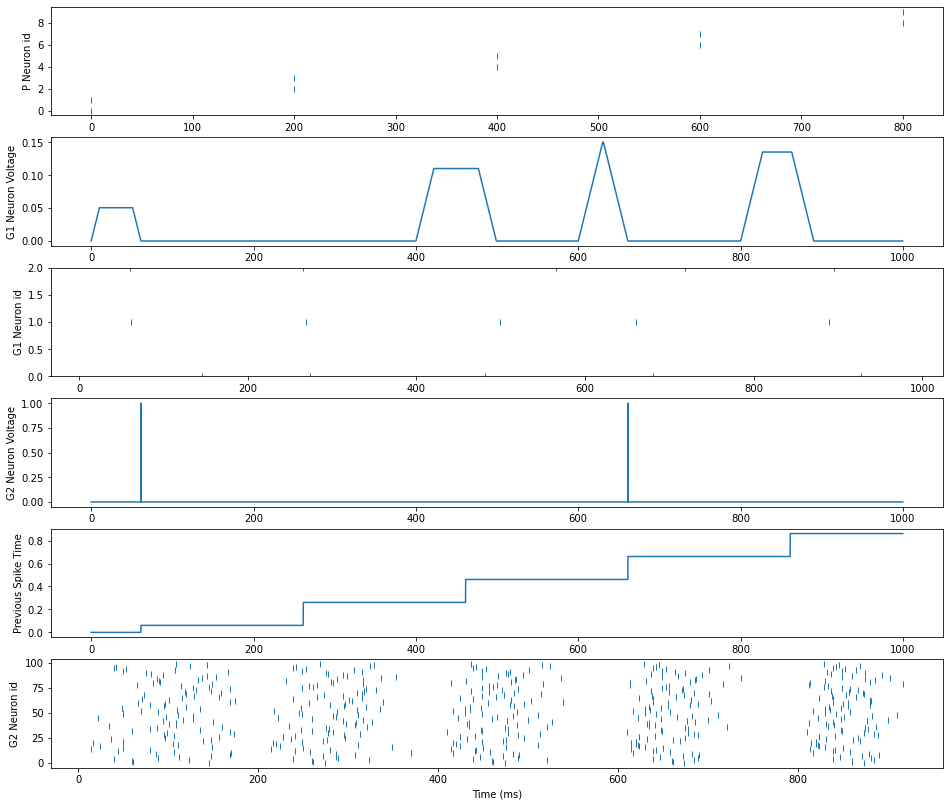

In [12]:
# The following plots output from the different monitors
fig, axs = plt.subplots(6,1,figsize=(16,14), gridspec_kw={'height_ratios': [2, 2, 2, 2, 2, 2]})
subplot(6,1,1)
plot(SMP.t/ms, SMP.i,'|')
xlabel('Time (ms)')
ylabel('P Neuron id')

subplot(6,1,2)
plot(M1.t/ms, M1.v[target_neuron].T)
xlabel('Time (ms)')
ylabel('G1 Neuron Voltage')

subplot(6,1,3)
plot(SM1.t/ms, SM1.i,'|')
xlabel('Time (ms)')
ylabel('G1 Neuron id')
plt.ylim(y_low,y_high)

subplot(6,1,4)
plot(M2.t/ms, M2.v[target_neuron].T)
xlabel('Time (ms)')
ylabel('G2 Neuron Voltage')
#plt.xlim(12000,14000)

subplot(6,1,5)
plot(M2ts.t/ms, M2ts.ts[target_neuron].T)
xlabel('Time (ms)')
ylabel('Previous Spike Time')
#plt.xlim(12000,14000)

subplot(6,1,6)
plot(SM2.t/ms, SM2.i,'|')
xlabel('Time (ms)')
ylabel('G2 Neuron id')
#plt.ylim(y_low,y_high)


# UnBinding: Brian 2 Code  =====================================

![title](img/Fig9.png)

In [13]:
#--------------------------------------------------------------------------------------------------------
#This section of the code implements the Brian2 neuromorphic circuit which unbinds the vector. 
#The unbound vector and a selected role vector are processed to give the corresponding 'noisy' filler vector.
# which is then compared to the memory vectors to find the best match (i.e. the clean-up memory operation)


# We first generate the time delay data_matrix which will be used in the 'clean-up memory'  so that the input vector 
# time delay in each slot plus the delay matrix line up at the number of bits per slot 
# (e.g. a time delay in slot 0 of the input vector of say 10 will have a corresponding delay of 90 in the corresponding
#  data_matrix so that if this vector is received then the match condition is an input potential to the neuron at 100)

data_matrix = bits_per_slot - P_matrix

net2=Network()

print()

# To pass the sparse vector from Net1 into Net2 we create a SpikeGeneratorGroup that uses the P1_timing from Net1 to generate
# the sparse bound vector which is the input to NeuronGroup G6 (S6).
P1 = SpikeGeneratorGroup(slots_per_vector, np.arange(slots_per_vector), P1_timing * ms)

net2.add(P1)

# We now define the neuron potential equations and resets plus a preset
equ2 = '''
dv/dt = -v/tau : 1 
I : 1
tau : second
'''

equ3 ='''
dv/dt = (I)/tau : 1 
I : 1
tau : second
'''

reset3 = '''
I=1.0
v=0.0
'''
preset1 = '''
I = 1.0
v= 0.0
'''

# NeuronGroup G7 is a recurrent circuit which simply repeates the sparse bound vector from P1 every 3*bits milliseconds 
# and feeds the output vector into the G6 neurongroup (see S7 below)

G7 = NeuronGroup(slots_per_vector, equ2, threshold='v>=1.0', reset='v=0.0', method='euler')
G7.v=0.0
G7.tau = 0.5*ms

SP17 = Synapses(P1, G7, 'w : 1',on_pre= 'v=1.25')
SP17.connect(j='i')
#SP17.delay = bits_per_slot*ms


S77 = Synapses(G7, G7, 'w : 1',on_pre= 'v=1.25')
S77.connect(j='i')
#S77.delay = 3*bits_per_slot*ms
S77.delay = 2 * bits_per_slot * ms

net2.add(G7)
net2.add(SP17)
net2.add(S77)



#Calculate the array for the input spike generator which cycles through the role vectors 0,2,4 etc
array2 = np.ones(mem_size) * slots_per_vector * bits_per_slot
for b in range(0,Num_bound):
    #array2[b*2] = (b*3)*input_delay
    array2[b*2] = (b*2)*input_delay

P2 = SpikeGeneratorGroup(mem_size,np.arange(mem_size), (array2)*ms)
net2.add(P2)

The G6 neuron group is stimulated from the P spike generator group with and the G7 neuron group. The P spike generator generates a role vector role using the time delay on the G6 dendrites obtained from the P_matrix (S5.delay) and the G6 neuron group produces the sparse bound vector.

The G6 neurons perform the subtraction operation on the selected vectors. In this case Equ3 is a linearly increasing function with a time constant of bits_per_slot*ms (I=1.0).  On receiving the first spike from either role or filler vector the value of I=0.0 which holds the neuron potential constant until the second spike is received when I again becomes 1.0  and the neuron potential continues to increase until the threshold value v>1.0 when it fires. To give the required modulus addition the value of I is maintained at 1.0 to ensure a second vector is generated. One of these two vector will have the correct modulus timings and so we compare both vectors in the final neuron group stage (G8) to get the best match. 

In [14]:
G6 = NeuronGroup(slots_per_vector, equ3, threshold='v>=1.0', reset=reset3, method='euler', refractory ='2*Num_bound*ms')

G6.v =0.0
G6.I = 1.0
G6.tau = bits_per_slot * ms

net2.add(G6)



S5 = Synapses(P2, G6, 'w : 1',on_pre= 'I = (I-1)%2')

range_array2 = range(0, slots_per_vector)
for n in range(0,mem_size):
    S5.connect(i=n,j=range_array2)     
S5.delay = np.reshape(P_matrix, mem_size * slots_per_vector) * ms

net2.add(S5)

S6 = Synapses(P2, G6, 'w : 1',on_pre= preset1)

for n in range(0,mem_size):
    S6.connect(i=n,j=range_array2)    

net2.add(S6)


S7 = Synapses(G7, G6, 'w : 1',on_pre= 'I = (I-1)%2')
S7.connect(j='i')



net2.add(S7)


This final NeuronGroup,G8, stage is the clean up memory operation using the transpose of the data_matrix to set the synaptic delays on the G8 dendrites. We only produce one output spike per match by using the refractory operator to suppress any further spikes. This could be improved to choose the larget matching spike.

In [15]:
G8 = NeuronGroup(mem_size, equ2, threshold='v >= 13.0', reset='v=0.0', method='euler')

G8.v = 1.0
G8.tau = 2.0*ms

net2.add(G8)

range_array3 = range(0,mem_size)

S8 = Synapses(G6, G8, on_pre='v += 1.0')

for n in range(0, slots_per_vector):
    S8.connect(i=n,j=range_array3)  

data_matrix2 = np.transpose(data_matrix) 
S8.delay = np.reshape(data_matrix2, mem_size * slots_per_vector) * ms
net2.add(S8)

# Create the required monitors

SMP1 = SpikeMonitor(P1)

net2.add(SMP1)

SM7 = SpikeMonitor(G7)
net2.add(SM7)

SMP2 = SpikeMonitor(P2)

net2.add(SMP2)

M6 = StateMonitor(G6, 'v', record=True)

net2.add(M6)

SM6 = SpikeMonitor(G6)

net2.add(SM6)


M8 = StateMonitor(G8, 'v', record=True)

net2.add(M8)

SM8 = SpikeMonitor(G8)

net2.add(SM8)

net2.run(((2*Num_bound) * bits_per_slot + 3) * ms)

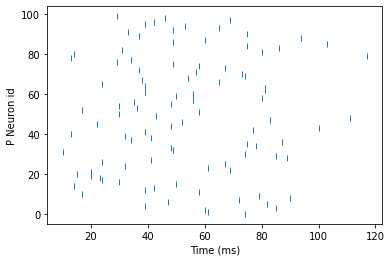

Text(0, 0.5, 'G8 Neuron id')

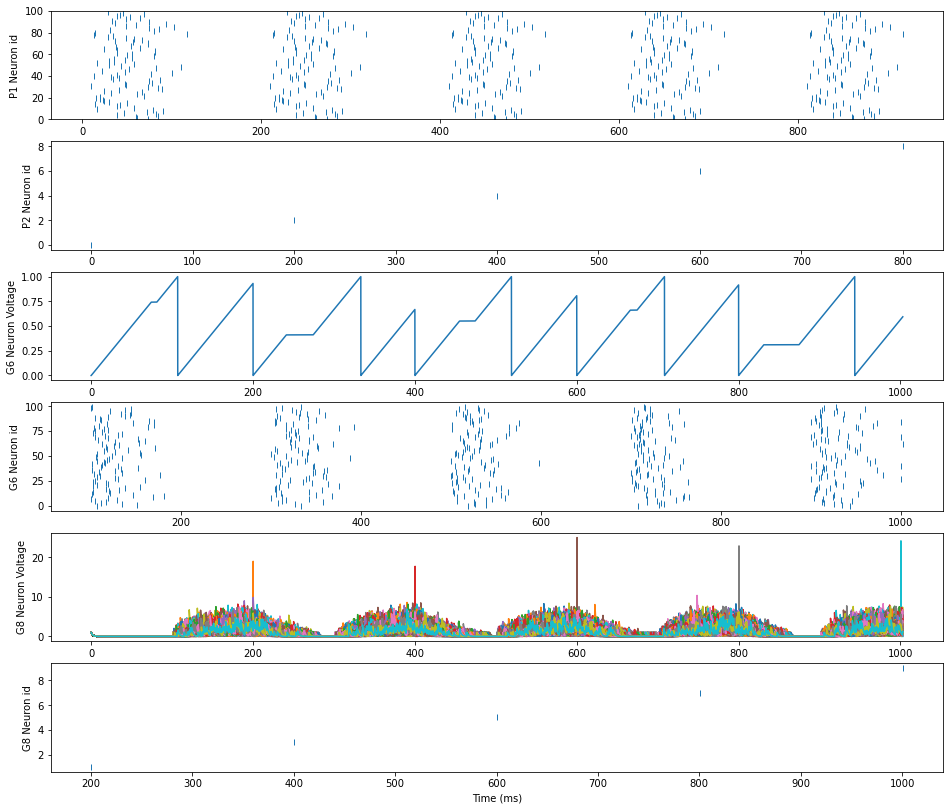

In [16]:
# Plot the sparse bound vector

plot(SMP1.t/ms, SMP1.i,'|')
xlabel('Time (ms)')
ylabel('P Neuron id')
show()

fig, axs = plt.subplots(6,1,figsize=(16,14), gridspec_kw={'height_ratios': [2, 2, 2, 2, 2, 2]})

# Plot the other monitors
subplot(6,1,1)
plot(SM7.t/ms, SM7.i,'|')
xlabel('Time (ms)')
ylabel('P1 Neuron id')
plt.ylim(0, slots_per_vector)


subplot(6,1,2)
plot(SMP2.t/ms, SMP2.i,'|')
xlabel('Time (ms)')
ylabel('P2 Neuron id')
#plt.xlim(0,2*bits_per_slot*Num_bound)
#plt.xlim(bits_per_slot*Num_bound-100,2*bits_per_slot*(Num_bound+1))
#plt.ylim(y_low,y_high)

subplot(6,1,3)
plot(M6.t/ms, M6.v[0].T)
xlabel('Time (ms)')
ylabel('G6 Neuron Voltage')
#plt.xlim(0,2*bits_per_slot*Num_bound)
#plt.xlim(bits_per_slot*Num_bound-100,2*bits_per_slot*(Num_bound+1))

subplot(6,1,4)
plot(SM6.t/ms, SM6.i,'|')
xlabel('Time (ms)')
ylabel('G6 Neuron id')

subplot(6,1,5)
plot(M8.t/ms, M8.v.T)
xlabel('Time (ms)')
ylabel('G8 Neuron Voltage')

subplot(6,1,6)
plot(SM8.t/ms, SM8.i,'|')
xlabel('Time (ms)')
ylabel('G8 Neuron id')